In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


#Visualizations library
import seaborn as sns 
import matplotlib.pyplot as plt


#Stats library
from scipy import stats
from scipy.stats import norm, skew 

#Preprocessing Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p


# Modellling Librries
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LassoCV, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

import xgboost as xgb

import os
# print(os.listdir("../House Price Predictor"))

# Any results you write to the current directory are saved as output.

In [2]:
# !pip install xgboost

In [4]:
# train = pd.read_csv('../input/blackfriday-train/train.csv')
# test = pd.read_csv('../input/blackfriday-test/test.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


id_train = train.index
id_test = test.index

In [5]:
train.shape

(550068, 12)

In [5]:
train.head(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [7]:
train.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

In [8]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [9]:
test.nunique()

User_ID                       5891
Product_ID                    3491
Gender                           2
Age                              7
Occupation                      21
City_Category                    3
Stay_In_Current_City_Years       5
Marital_Status                   2
Product_Category_1              18
Product_Category_2              17
Product_Category_3              15
dtype: int64

In [6]:
pr_Id = test.Product_ID

In [7]:
purchase = train.Purchase

/home/saurabh/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 9263.97 and sigma = 5023.06



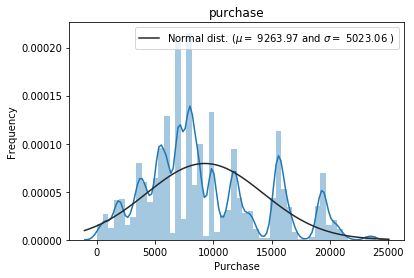

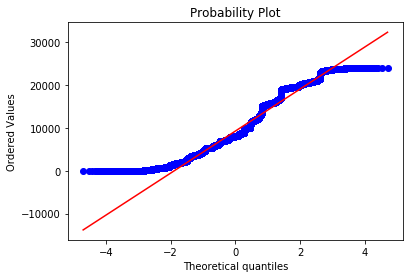

In [120]:


# Plotting Target vaiable


sns.distplot(purchase, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(purchase)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('purchase')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(purchase, plot=plt)
plt.show()



In [8]:
meanPrice = train.groupby('Product_ID')['Purchase'].mean()

In [9]:
meanPrice = meanPrice.rename('MeanPurchase')

In [10]:
combine = pd.concat([train, test], sort=True, ignore_index=True)
combine.drop('Purchase', axis=1, inplace=True)

# Missing Values

In [11]:
# Dataframe that shows Null count and percent odf null counts of all features.
def checkNull(dataFrame):
    nullCount = dataFrame.isnull().sum().sort_values(ascending=False)
    nullCount = nullCount[nullCount != 0]
    nullPercent = ((nullCount)/combine.shape[0]) * 100
    nullCols = pd.DataFrame([nullCount, nullPercent], index=['Count', 'Percent']).transpose()
    return nullCols

In [12]:
nullCols = checkNull(combine)
nullCols.head(10)

,Count,Percent
Product_Category_3,545809.0,69.648078
Product_Category_2,245982.0,31.388587


In [13]:
combine.fillna(-999, inplace=True)

# Correlation

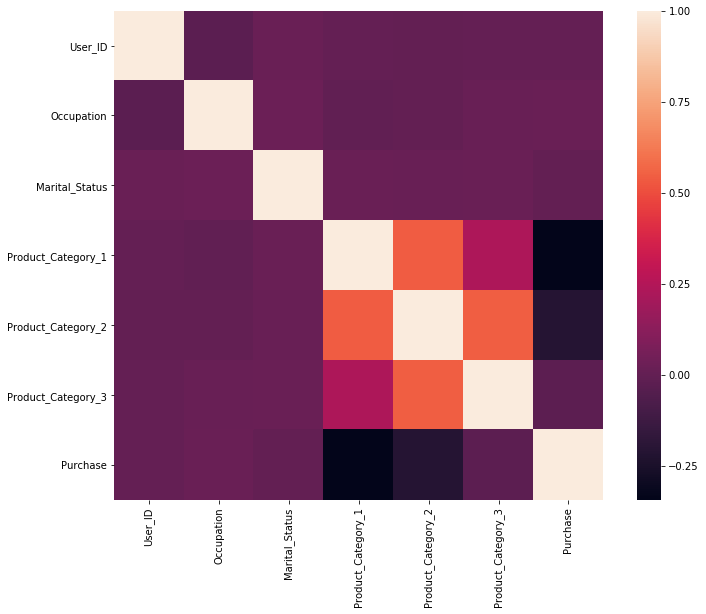

In [22]:
# Visualising Correlation

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, square=True)

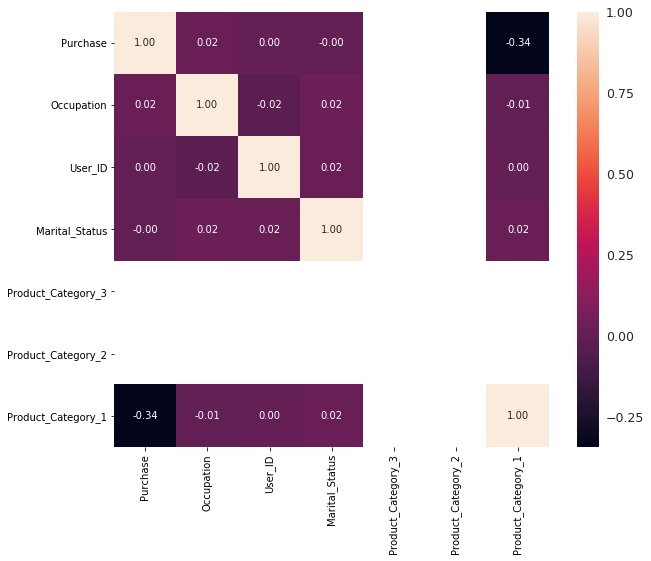

In [23]:
k = 12
selectedCols = corrmat.nlargest(k, 'Purchase')['Purchase'].index
cm = np.corrcoef(train[selectedCols].values.T)
f, ax = plt.subplots(figsize=(10, 8))

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size' : 10}, yticklabels=selectedCols.values, xticklabels=selectedCols.values)
plt.show()

# Feature Engeneering

In [14]:
lowerAgeDix = {'0-17': 0, '18-25': 18, '26-35': 26, '36-45': 36, '46-50': 46, '51-55': 51, '55+': 55 }

In [15]:
upperAgeDix = {'0-17': 17, '18-25': 25, '26-35': 35, '36-45': 45, '46-50': 50, '51-55': 55, '55+': 75 }

In [16]:
combine['Lower_Age'] = combine['Age'].map(lowerAgeDix)

In [17]:
combine['Upper_Age'] = combine['Age'].map(upperAgeDix)

In [18]:
combine.Stay_In_Current_City_Years = combine.Stay_In_Current_City_Years.replace('4+', 4)

In [19]:
combine = combine.join(meanPrice, on='Product_ID')

In [134]:
train['MeanPurchase'].corr(Purchase)

NameError: name 'Purchase' is not defined

In [122]:
feat = 'MeanPurchase'
combine[feat + '-s2'] = combine[feat] ** 2
combine[feat + '-s3'] = combine[feat] ** 3
combine[feat + '-Sq'] = np.sqrt(combine[feat])

In [123]:
combine.head()

,Age,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,User_ID,Lower_Age,Upper_Age,MeanPurchase,...,Marital_Status_0,Marital_Status_1,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,MeanPurchase-s2,MeanPurchase-s3,MeanPurchase-Sq
0,0,10,3,-999,-999,69042,1000001,0,17,11870.863436,...,1,0,0,0,0,1,0,1.409174e+08,1.672811e+12,108.953492
1,0,10,1,6,14,248942,1000001,0,17,16304.030981,...,1,0,0,0,0,1,0,2.658214e+08,4.333961e+12,127.687239
2,0,10,12,-999,-999,87842,1000001,0,17,1237.892157,...,1,0,0,0,0,1,0,1.532377e+06,1.896917e+09,35.183692
3,0,10,12,14,-999,85442,1000001,0,17,1455.140762,...,1,0,0,0,0,1,0,2.117435e+06,3.081165e+09,38.146307
4,6,16,8,-999,-999,285442,1000002,55,75,7692.763547,...,1,0,1,0,0,0,0,5.917861e+07,4.552471e+11,87.708401


In [37]:
combine.Occupation.unique()

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6])

In [124]:
combine.dtypes

Age                               int64
Occupation                        int64
Product_Category_1                int64
Product_Category_2                int64
Product_Category_3                int64
Product_ID                        int64
User_ID                           int64
Lower_Age                         int64
Upper_Age                         int64
MeanPurchase                    float64
City_Category_A                   uint8
City_Category_B                   uint8
City_Category_C                   uint8
Gender_F                          uint8
Gender_M                          uint8
Marital_Status_0                  uint8
Marital_Status_1                  uint8
Stay_In_Current_City_Years_4      uint8
Stay_In_Current_City_Years_0      uint8
Stay_In_Current_City_Years_1      uint8
Stay_In_Current_City_Years_2      uint8
Stay_In_Current_City_Years_3      uint8
MeanPurchase-s2                 float64
MeanPurchase-s3                 float64
MeanPurchase-Sq                 float64


In [20]:
combine = pd.get_dummies(combine, columns=['City_Category', 'Gender', 'Marital_Status', 'Stay_In_Current_City_Years'])

In [21]:
combine['Product_ID'] = combine['Product_ID'].str[1:]

In [41]:
combine.index.nunique()

783667

In [22]:
combine['Product_ID'] = combine['Product_ID'].astype('int64')
combine['Product_Category_2'] = combine['Product_Category_2'].astype('int64')
combine['Product_Category_3'] = combine['Product_Category_3'].astype('int64')

In [23]:
le = LabelEncoder()

In [24]:
combine['Age'] = le.fit_transform(combine.Age)

In [45]:
combine.dtypes

Age                               int64
Occupation                        int64
Product_Category_1                int64
Product_Category_2                int64
Product_Category_3                int64
Product_ID                        int64
User_ID                           int64
Lower_Age                         int64
Upper_Age                         int64
MeanPurchase                    float64
City_Category_A                   uint8
City_Category_B                   uint8
City_Category_C                   uint8
Gender_F                          uint8
Gender_M                          uint8
Marital_Status_0                  uint8
Marital_Status_1                  uint8
Stay_In_Current_City_Years_4      uint8
Stay_In_Current_City_Years_0      uint8
Stay_In_Current_City_Years_1      uint8
Stay_In_Current_City_Years_2      uint8
Stay_In_Current_City_Years_3      uint8
dtype: object

In [46]:
combine.Product_Category_2.unique()

array([-999,    6,   14,    2,    8,   15,   16,   11,    5,    3,    4,
         12,    9,   10,   17,   13,    7,   18])

In [125]:
train = combine[combine.index < 550068].copy()
test = combine[combine.index >= 550068].copy()

In [48]:
combine.index

RangeIndex(start=0, stop=783667, step=1)

In [26]:
train.shape

(550068, 22)

In [50]:
train.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            550058, 550059, 550060, 550061, 550062, 550063, 550064, 550065,
            550066, 550067],
           dtype='int64', length=550068)

In [51]:
purchase.shape

(550068,)

In [59]:
test.shape

(233599, 22)

In [126]:
test.index = range(233599)

In [54]:
test.index

RangeIndex(start=0, stop=233599, step=1)

# Modelling

In [127]:
x_train, cv, y_train, y_cv = train_test_split(train, purchase, test_size=0.25, random_state=42)

In [56]:
x_train.index

Int64Index([212363,  41298, 470717, 394764, 265659, 111363,  98061, 146374,
            348055, 482833,
            ...
            175203,  87498, 521430, 137337,  54886, 110268, 259178, 365838,
            131932, 121958],
           dtype='int64', length=412551)

In [57]:
y_train.index

Int64Index([212363,  41298, 470717, 394764, 265659, 111363,  98061, 146374,
            348055, 482833,
            ...
            175203,  87498, 521430, 137337,  54886, 110268, 259178, 365838,
            131932, 121958],
           dtype='int64', length=412551)

In [57]:
parameters = open("parameters.txt", 'w')

In [128]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [62]:
# print("score: ", (rmse_cv(model, cv, y_cv)).mean())

In [129]:
def modelFit(alg, x_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    alg.fit(x_train, y_train, eval_metric='rmse')
    
#     dtrain_precitions = alg.predict(x_train)
    
#     print("RMSE score(on CV): ", (rmse_cv(xgbMod, x_cv, y_cv)).mean())
#     print("RMSE score(on train): ", (rmse_cv(xgbMod, x_train, y_train)).mean())
#     dtrain_predprob = alg.predict_proba(x_train)[:,1]
    
#     print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
#     print("RMSE score: ", (rmse_cv(model, cv, y_cv)).mean())                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    return alg
    
    
    

In [64]:
xgb1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:linear',
    scale_pos_weight=1,
    seed=27
)
xgbMod = modelFit(xgb1, x_train, y_train)

In [66]:
print("RMSE score: ", (rmse_cv(xgbMod, cv, y_cv)).mean())
print("RMSE score: ", (rmse_cv(xgbMod, x_train, y_train)).mean())

In [68]:
param_test1 = {
    'max_depth':range(3, 10, 2),
    'min_child_weight':range(1, 6, 2)
}

# scoreCalc = np.sqrt(metrics.mean_squared_error)

gsearch = GridSearchCV(estimator= XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=5,
                                               min_child_weight=1, gamma=0, subsample=0.8, 
                                               colsample_bytree=0.8, objective='reg:linear', scale_pos_weight=1,
                                               seed=27),
                      param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)

gsearch.fit(x_train, y_train)
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

In [69]:
param_test2 = {
    'max_depth':[8, 9, 10],
    'min_child_weight':[2, 3, 4]
}

# scoreCalc = np.sqrt(metrics.mean_squared_error)

gsearch2 = GridSearchCV(estimator= XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=5,
                                               min_child_weight=2, gamma=0, subsample=0.8, 
                                               colsample_bytree=0.8, objective='reg:linear', scale_pos_weight=1,
                                               seed=27),
                      param_grid=param_test2, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch2.fit(x_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [71]:
param_test2b = {
 'max_depth':[10, 11, 12, 13],
}


gsearch2b = GridSearchCV(estimator= XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=10,
                                               min_child_weight=2, gamma=0, subsample=0.8, 
                                               colsample_bytree=0.8, objective='reg:linear', scale_pos_weight=1,
                                               seed=27),
                      param_grid=param_test2b, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch2b.fit(x_train, y_train)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6289445.42855, std: 19366.17645, params: {'max_depth': 10},
  mean: -6277058.04942, std: 21474.78330, params: {'max_depth': 11},
  mean: -6285636.69616, std: 21275.66642, params: {'max_depth': 12},
  mean: -6307250.03271, std: 18344.13432, params: {'max_depth': 13}],
 {'max_depth': 11},
 -6277058.049419234)

In [73]:
param_test2c = {
    'max_depth':[10, 11],
    'min_child_weight': [2, 3]
}


gsearch2c = GridSearchCV(estimator= XGBRegressor(learning_rate=0.1, n_estimators=140, max_depth=10,
                                               min_child_weight=2, gamma=0, subsample=0.8, 
                                               colsample_bytree=0.8, objective='reg:linear', scale_pos_weight=1,
                                               seed=27),
                      param_grid=param_test2c, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch2c.fit(x_train, y_train)
gsearch2c.grid_scores_, gsearch2c.best_params_, gsearch2c.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6289445.42855, std: 19366.17645, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: -6295983.30779, std: 18720.26710, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: -6277058.04942, std: 21474.78330, params: {'max_depth': 11, 'min_child_weight': 2},
  mean: -6277742.52351, std: 21455.45070, params: {'max_depth': 11, 'min_child_weight': 3}],
 {'max_depth': 11, 'min_child_weight': 2},
 -6277058.049419234)

In [61]:
for key, val in gsearch2c.best_params_.items():
    parameters.write(key + " : " + str(val) + '\n')
parameters.flush()
os.fsync(parameters.fileno())

In [91]:
paramsDix = {}
paramsDix.update(gsearch2c.best_params_)

In [74]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=11,
                                                 min_child_weight=2, gamma=0, subsample=0.8,
                                                 colsample_bytree=0.8, objective= 'reg:linear',
                                                 scale_pos_weight=1,seed=27),
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch3.fit(x_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6277058.04942, std: 21474.78330, params: {'gamma': 0.0},
  mean: -6277058.04942, std: 21474.78330, params: {'gamma': 0.1},
  mean: -6277058.04942, std: 21474.78330, params: {'gamma': 0.2},
  mean: -6277058.04942, std: 21474.78330, params: {'gamma': 0.3},
  mean: -6277058.04942, std: 21474.78330, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -6277058.049419234)

In [93]:
for key, val in gsearch3.best_params_.items():
    parameters.write(key + " : " + str(val) + '\n')
parameters.flush()
os.fsync(parameters.fileno())

In [92]:
paramsDix.update(gsearch3.best_params_)

In [49]:
xgb2 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=10,
    min_child_weight=2,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:linear',
    scale_pos_weight=1,
    seed=27
)
xgbMod2 = modelFit(xgb2, x_train, y_train)

KeyboardInterrupt: 

In [89]:
print("RMSE score: ", (rmse_cv(xgbMod2, cv, y_cv)).mean())
print("RMSE score: ", (rmse_cv(xgbMod2, x_train, y_train)).mean())

RMSE score:  2581.046258153347
RMSE score:  2507.8737077824503


In [34]:
paramsDix = {'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.0}

In [35]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=paramsDix['max_depth'],
                                                 min_child_weight=paramsDix['min_child_weight'], gamma=paramsDix['gamma'], subsample=0.8,
                                                 colsample_bytree=0.8, objective= 'reg:linear',
                                                 scale_pos_weight=1,seed=27),
                        param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch4.fit(x_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6372018.90254, std: 32378.89372, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -6346538.05114, std: 25224.01492, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -6346463.75426, std: 24662.18929, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -6323319.21857, std: 22062.99145, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -6334743.99836, std: 31545.14253, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -6295251.64968, std: 31620.04834, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -6287808.72351, std: 27102.22002, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -6271458.33036, std: 20151.67584, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -6333870.79554, std: 21528.04716, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -6289709.70166, std: 22868.21734, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -6277058.04942, std: 21474.78330, params: 

In [36]:
paramsDix.update(gsearch4.best_params_)

In [38]:
param_test5 = {
 'subsample':[i/100.0 for i in range(int(paramsDix['subsample']*100) - 5, int(paramsDix['subsample']*100) + 10, 5)],
 'colsample_bytree':[i/100.0 for i in range(int(paramsDix['colsample_bytree']*100) - 5,int(paramsDix['colsample_bytree']*100) + 10, 5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=paramsDix['max_depth'],
                                                 min_child_weight=paramsDix['min_child_weight'], gamma=paramsDix['gamma'], subsample=paramsDix['subsample'],
                                                 colsample_bytree=paramsDix['colsample_bytree'], objective= 'reg:linear',
                                                 scale_pos_weight=1,seed=27),
                        param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch5.fit(x_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6253100.76287, std: 18038.98794, params: {'colsample_bytree': 0.85, 'subsample': 0.85},
  mean: -6250703.24181, std: 21656.98376, params: {'colsample_bytree': 0.85, 'subsample': 0.9},
  mean: -6246372.22998, std: 23627.22252, params: {'colsample_bytree': 0.85, 'subsample': 0.95},
  mean: -6250391.34010, std: 19954.36330, params: {'colsample_bytree': 0.9, 'subsample': 0.85},
  mean: -6246583.70862, std: 26585.29999, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: -6239636.39343, std: 8522.21635, params: {'colsample_bytree': 0.9, 'subsample': 0.95},
  mean: -6246714.72532, std: 22970.68908, params: {'colsample_bytree': 0.95, 'subsample': 0.85},
  mean: -6243540.88011, std: 18625.94170, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: -6240331.35108, std: 19162.41929, params: {'colsample_bytree': 0.95, 'subsample': 0.95}],
 {'colsample_bytree': 0.9, 'subsample': 0.95},
 -6239636.393433565)

In [39]:
for key, val in gsearch5.best_params_.items():
    parameters.write(key + " : " + str(val) + '\n')
parameters.flush()
os.fsync(parameters.fileno())

In [40]:
paramsDix.update(gsearch5.best_params_)

In [41]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=paramsDix['max_depth'],
                                                 min_child_weight=paramsDix['min_child_weight'], gamma=paramsDix['gamma'], subsample=paramsDix['subsample'],
                                                 colsample_bytree=paramsDix['colsample_bytree'], objective= 'reg:linear',
                                                 scale_pos_weight=1,seed=27),
                        param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch6.fit(x_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6239636.39403, std: 8522.21500, params: {'reg_alpha': 1e-05},
  mean: -6243893.16014, std: 13895.62056, params: {'reg_alpha': 0.01},
  mean: -6247837.86461, std: 10133.45347, params: {'reg_alpha': 0.1},
  mean: -6238094.45332, std: 12716.54732, params: {'reg_alpha': 1},
  mean: -6247341.12581, std: 15029.51455, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -6238094.453318961)

In [42]:
paramsDix.update(gsearch6.best_params_)

In [43]:
paramsDix

{'max_depth': 11,
 'min_child_weight': 2,
 'gamma': 0.0,
 'colsample_bytree': 0.9,
 'subsample': 0.95,
 'reg_alpha': 1}

In [44]:
alp = paramsDix['reg_alpha']

param_test7 = {
 'reg_alpha':[0, alp/10, alp/5, alp, alp*2.5, alp*5]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=paramsDix['max_depth'],
                                                 min_child_weight=paramsDix['min_child_weight'], gamma=paramsDix['gamma'], subsample=paramsDix['subsample'],
                                                 colsample_bytree=paramsDix['colsample_bytree'], objective= 'reg:linear',
                                                 scale_pos_weight=1,seed=27),
                        param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch7.fit(x_train, y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

/home/saurabh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -6239636.39343, std: 8522.21635, params: {'reg_alpha': 0},
  mean: -6247837.86461, std: 10133.45347, params: {'reg_alpha': 0.1},
  mean: -6236427.27810, std: 17637.37508, params: {'reg_alpha': 0.2},
  mean: -6238094.45332, std: 12716.54732, params: {'reg_alpha': 1},
  mean: -6259994.33069, std: 22245.84958, params: {'reg_alpha': 2.5},
  mean: -6243386.85572, std: 8504.22906, params: {'reg_alpha': 5}],
 {'reg_alpha': 0.2},
 -6236427.278104601)

In [45]:
for key, val in gsearch7.best_params_.items():
    parameters.write(key + " : " + str(val) + '\n')
parameters.flush()
os.fsync(parameters.fileno())
parameters.close()

In [46]:
paramsDix.update(gsearch7.best_params_)

In [47]:
paramsDix


{'max_depth': 11,
 'min_child_weight': 2,
 'gamma': 0.0,
 'colsample_bytree': 0.9,
 'subsample': 0.95,
 'reg_alpha': 0.2}

In [130]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=paramsDix['max_depth'],
 min_child_weight=paramsDix['min_child_weight'],
 gamma=paramsDix['gamma'],
 subsample=paramsDix['subsample'],
 colsample_bytree=paramsDix['colsample_bytree'],
 reg_alpha=paramsDix['reg_alpha'],
 objective= 'reg:linear',
 scale_pos_weight=1,
 seed=27)
xgbMod3 = modelFit(xgb3, x_train, y_train)

In [135]:
print("RMSE score: ", (rmse_cv(xgbMod3, cv, y_cv)).mean())
# print("RMSE score: ", (rmse_cv(xgbMod3, x_train, y_train)).mean())

RMSE score:  2578.2511910542453


In [131]:
y_predict = xgbMod3.predict(test)

In [67]:
cv_predict = xgbMod3.predict(cv)

In [70]:
type(cv_predict)

numpy.ndarray

In [72]:
(y_cv.index)

Int64Index([ 84432,  72724, 197032, 353704,  91198, 263977, 340456,  24094,
            157277, 531759,
            ...
            130341, 517154, 438290, 517680, 471072, 288415, 204984, 135828,
            243905, 166147],
           dtype='int64', length=137517)

In [132]:
submission = pd.DataFrame({
    'User_ID': test.User_ID,
    'Product_ID': pr_Id,
    'Purchase': y_predict
})

In [99]:
cvDF = pd.DataFrame({
    'Ind': cv.index,
    'User_ID': y_cv.index,
    'Product_ID': cv['Product_ID'],
    'Purchase': y_cv,
    'PredictPurchase': cv_predict,
    'MeanPurchase': cv['MeanPurchase'],
    'Diff': y_cv - cv_predict
})

,User_ID,Product_ID,Purchase,PredictPurchase,MeanPurchase,Diff
84432,84432,351342,19142,12866.092773,13116.614695,6275.907227
72724,72724,237542,15513,15693.242188,16804.573888,-180.242188
197032,197032,116242,7802,7780.867676,8045.737762,21.132324
353704,353704,16742,15455,8915.732422,10191.428571,6539.267578
91198,91198,2242,4492,12709.725586,13548.919192,-8217.725586
263977,263977,112242,6965,7714.445801,7371.000000,-749.445801
340456,340456,121642,8763,7629.695312,7178.317702,1133.304688
24094,24094,274042,19347,16168.308594,15490.825263,3178.691406
157277,157277,258742,7017,6844.993164,7002.630705,172.006836
531759,531759,228442,15594,13568.841797,12906.404110,2025.158203


In [100]:
cvDF.sort_values('Diff', =False)

,Ind,User_ID,Product_ID,Purchase,PredictPurchase,MeanPurchase,Diff
8498,8498,8498,82342,21140,8296.320312,9260.191617,12843.679688
322927,322927,322927,217342,19070,6811.425781,10432.269231,12258.574219
532813,532813,532813,197342,19572,7706.640625,8035.863014,11865.359375
397594,397594,397594,312742,20819,8968.568359,11147.984163,11850.431641
134250,134250,134250,31842,19669,7858.826660,10346.816754,11810.173828
394136,394136,394136,237242,19170,7361.325195,8066.437500,11808.674805
353703,353703,353703,369942,16276,4475.909668,5733.416667,11800.089844
371652,371652,371652,70442,19600,7888.608398,8461.378205,11711.391602
273492,273492,273492,38142,19705,8168.279785,15077.250000,11536.720703
377675,377675,377675,262342,21438,10293.298828,10401.523810,11144.701172


In [107]:
combine[combine.index == 8498]

,Age,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,User_ID,Lower_Age,Upper_Age,MeanPurchase,...,City_Category_C,Gender_F,Gender_M,Marital_Status_0,Marital_Status_1,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
8498,1,4,15,16,-999,82342,1001302,18,25,9260.191617,...,1,0,1,1,0,0,0,0,1,0


In [114]:
combine[combine.index == 12168]

,Age,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,User_ID,Lower_Age,Upper_Age,MeanPurchase,...,City_Category_C,Gender_F,Gender_M,Marital_Status_0,Marital_Status_1,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
12168,2,19,15,16,-999,82342,1001835,26,35,9260.191617,...,0,0,1,1,0,0,0,0,0,1


In [115]:
combine[combine.index == 470703]

,Age,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,User_ID,Lower_Age,Upper_Age,MeanPurchase,...,City_Category_C,Gender_F,Gender_M,Marital_Status_0,Marital_Status_1,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
470703,1,14,15,16,-999,82342,1000531,18,25,9260.191617,...,0,1,0,1,0,0,1,0,0,0


In [119]:
combine[combine.index == 234800]

,Age,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,User_ID,Lower_Age,Upper_Age,MeanPurchase,...,City_Category_C,Gender_F,Gender_M,Marital_Status_0,Marital_Status_1,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3
234800,2,12,15,16,-999,82342,1000195,26,35,9260.191617,...,0,0,1,0,1,1,0,0,0,0


In [118]:
cvDF[cvDF['Product_ID'] == 82342].sort_values('Diff', ascending=False)

,Ind,User_ID,Product_ID,Purchase,PredictPurchase,MeanPurchase,Diff
8498,8498,8498,82342,21140,8296.320312,9260.191617,12843.679688
234800,234800,234800,82342,16917,9765.549805,9260.191617,7151.450195
180389,180389,180389,82342,16722,9636.512695,9260.191617,7085.487305
178667,178667,178667,82342,17140,10136.317383,9260.191617,7003.682617
515334,515334,515334,82342,16687,9917.852539,9260.191617,6769.147461
38055,38055,38055,82342,17234,11191.999023,9260.191617,6042.000977
8049,8049,8049,82342,13250,7240.210938,9260.191617,6009.789062
187250,187250,187250,82342,16836,12372.915039,9260.191617,4463.084961
481283,481283,481283,82342,12882,9022.780273,9260.191617,3859.219727
520736,520736,520736,82342,12713,8889.655273,9260.191617,3823.344727


In [133]:
submission.to_csv('submissionXGBTuned1.csv', index=False)

In [ ]:
# ENet.fit(x_train, y_train)

In [ ]:
# y_predict = ENet.predict(test)